In [18]:
library(data.table)
library(zoo)
library(forecast)
library(ggplot2)
library(Metrics)
library(xts)
library(dygraphs)
library(knitr)
library(h2o)
library(rpart)
library(randomForest)

Loading required package: statmod

----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: 'h2o'

The following object is masked from 'package:timeDate':

    dayOfWeek

The following objects are masked from 'package:data.table':

    hour, month, week, year

The following objects are masked from 'package:stats':

    cor, sd, var

The following objects are masked from 'package:base':

    %*%, %in%, &&, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomFore

In [17]:
install.packages('randomForest', repos='http://cran.us.r-project.org')

package 'randomForest' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\jagpreet\AppData\Local\Temp\RtmpkbqTv8\downloaded_packages


In [3]:
data <- fread("E://Data Science//Rossmann//train.csv")
store <- fread("E://Data Science//Rossmann//store.csv")

In [4]:
str(data)

Classes 'data.table' and 'data.frame':	1017209 obs. of  9 variables:
 $ Store        : int  1 2 3 4 5 6 7 8 9 10 ...
 $ DayOfWeek    : int  5 5 5 5 5 5 5 5 5 5 ...
 $ Date         : chr  "2015-07-31" "2015-07-31" "2015-07-31" "2015-07-31" ...
 $ Sales        : int  5263 6064 8314 13995 4822 5651 15344 8492 8565 7185 ...
 $ Customers    : int  555 625 821 1498 559 589 1414 833 687 681 ...
 $ Open         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Promo        : int  1 1 1 1 1 1 1 1 1 1 ...
 $ StateHoliday : chr  "0" "0" "0" "0" ...
 $ SchoolHoliday: chr  "1" "1" "1" "1" ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [5]:
str(store)

Classes 'data.table' and 'data.frame':	1115 obs. of  10 variables:
 $ Store                    : int  1 2 3 4 5 6 7 8 9 10 ...
 $ StoreType                : chr  "c" "a" "a" "c" ...
 $ Assortment               : chr  "a" "a" "a" "c" ...
 $ CompetitionDistance      : int  1270 570 14130 620 29910 310 24000 7520 2030 3160 ...
 $ CompetitionOpenSinceMonth: int  9 11 12 9 4 12 4 10 8 9 ...
 $ CompetitionOpenSinceYear : int  2008 2007 2006 2009 2015 2013 2013 2014 2000 2009 ...
 $ Promo2                   : int  0 1 1 0 0 0 0 0 0 0 ...
 $ Promo2SinceWeek          : int  NA 13 14 NA NA NA NA NA NA NA ...
 $ Promo2SinceYear          : int  NA 2010 2011 NA NA NA NA NA NA NA ...
 $ PromoInterval            : chr  "" "Jan,Apr,Jul,Oct" "Jan,Apr,Jul,Oct" "" ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [6]:
summary(data[,as.Date(Date)])

        Min.      1st Qu.       Median         Mean      3rd Qu.         Max. 
"2013-01-01" "2013-08-17" "2014-04-02" "2014-04-11" "2014-12-12" "2015-07-31" 

In [7]:
#Earlier Date was Character format. It is now converted to DATE datatype.
data$Date<-as.Date(data$Date)

In [8]:
# Data split into training and testing
# Train data is from Jan 1, 2013 to 31
train <- data[data$Date<as.Date("2015-01-01")]
test <- data[data$Date>as.Date("2014-12-31")]

In [8]:
print("Training Dataset Details:")
summary(train$Date)
nrow(train)

print("Test Dataset Details:")
summary(test$Date)
nrow(test)

[1] "Training Dataset Details:"


        Min.      1st Qu.       Median         Mean      3rd Qu.         Max. 
"2013-01-01" "2013-06-25" "2013-12-17" "2013-12-19" "2014-06-10" "2014-12-31" 

[1] 780829

[1] "Test Dataset Details:"


        Min.      1st Qu.       Median         Mean      3rd Qu.         Max. 
"2015-01-01" "2015-02-22" "2015-04-16" "2015-04-16" "2015-06-08" "2015-07-31" 

[1] 236380

In [9]:
colnames(train)

[1] "Store"         "DayOfWeek"     "Date"          "Sales"        
[5] "Customers"     "Open"          "Promo"         "StateHoliday" 
[9] "SchoolHoliday"

In [10]:
#There are 1115 Unique store
#There are 3 different types of StateHolidays
train[, lapply(.SD, function(x) length(unique(x)))]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1,1115,7,730,20937,4000,2,2,4,2


In [11]:
#There are 1115 Unique store
#There are 2 different types of StateHolidays
test[, lapply(.SD, function(x) length(unique(x)))]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1,1115,7,212,16526,3336,2,2,3,2


In [19]:
table(train$Promo)/nrow(train) # 37% stores have promo code applied
table(test$Promo)/nrow(test) # 40% stores have promo code applied


        0         1 
0.6243672 0.3756328 


        0         1 
0.5990566 0.4009434 

In [12]:
table(train$StateHoliday)/nrow(train) # type a holiday is more as compared to others
table(test$StateHoliday)/nrow(test) # type a holiday is more as compared to others


          0           a           b           c 
0.970133025 0.018904267 0.005711878 0.005250830 


          0           a           b 
0.967302648 0.023263389 0.009433962 

In [14]:
table(train$SchoolHoliday)/nrow(train) # On 18.7% of the calender days, there was school holiday
table(test$SchoolHoliday)/nrow(test) # On 14.9% of the calender days, there was school holiday


        0         1 
0.8124583 0.1875417 


        0         1 
0.8507361 0.1492639 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


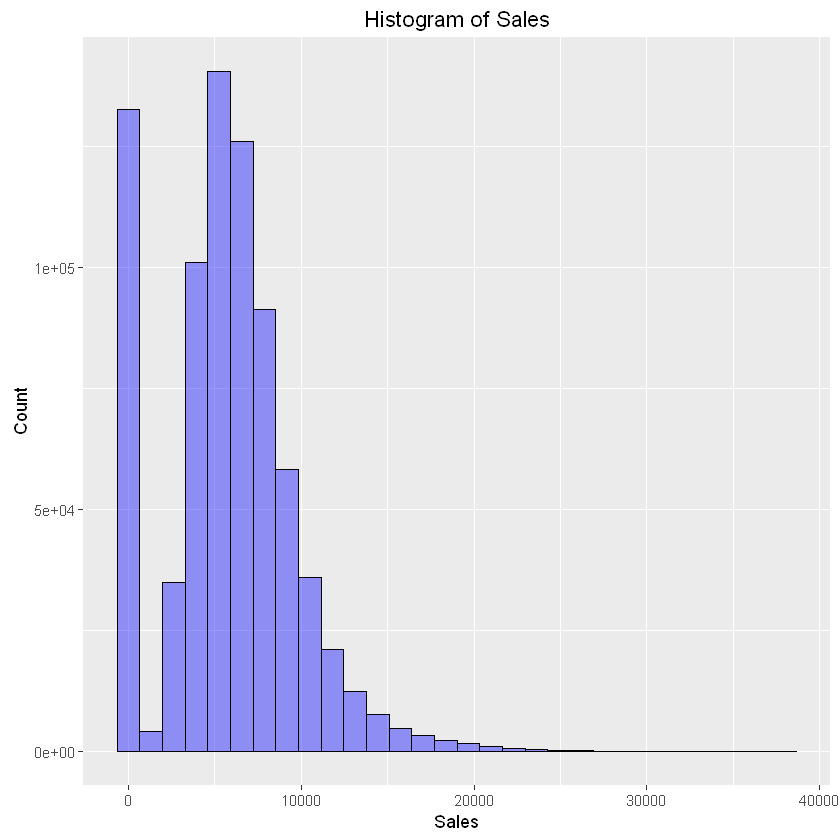

In [20]:
ggplot()+aes(train$Sales)+geom_histogram(col="black",fill="blue",alpha=0.4)+
labs(title="Histogram of Sales") + labs(x="Sales", y="Count")
# Sales are right skewed.
# High Peak in the initial signifies that there are stores with Sales = 0

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
: Removed 132525 rows containing non-finite values (stat_bin).Warning message:
: Removed 1 rows containing missing values (geom_bar).

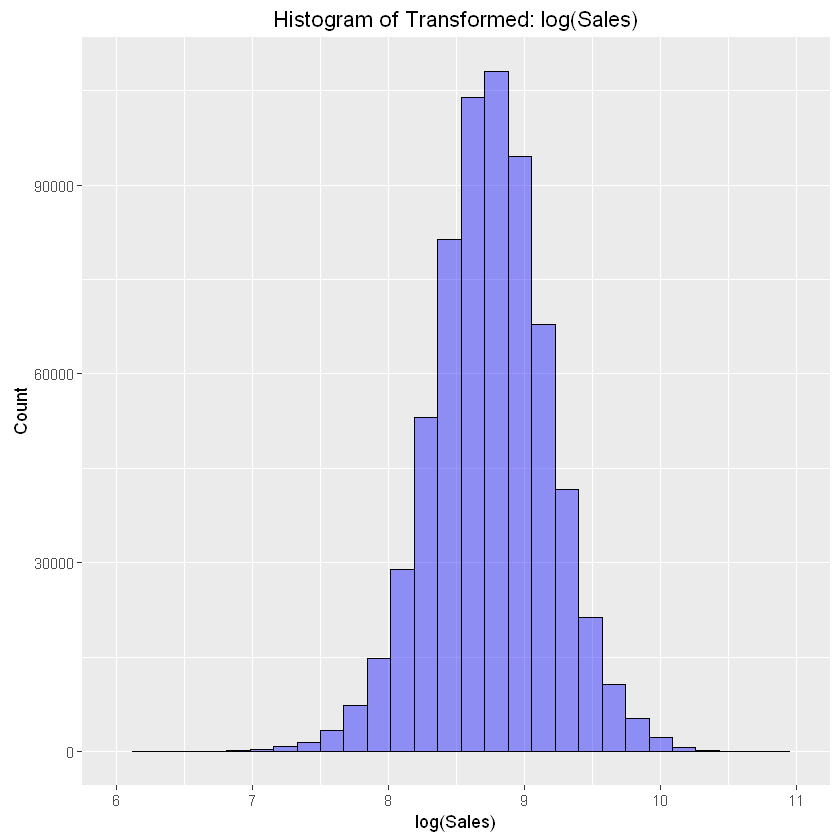

In [21]:
# After Log transformation, right skewed Sales gives Normal Distribution.
ggplot()+aes(log(train$Sales))+geom_histogram(col="black",fill="blue",alpha=0.4) +
labs(title="Histogram of Transformed: log(Sales)") + labs(x="log(Sales)", y="Count") + xlim(6,11)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


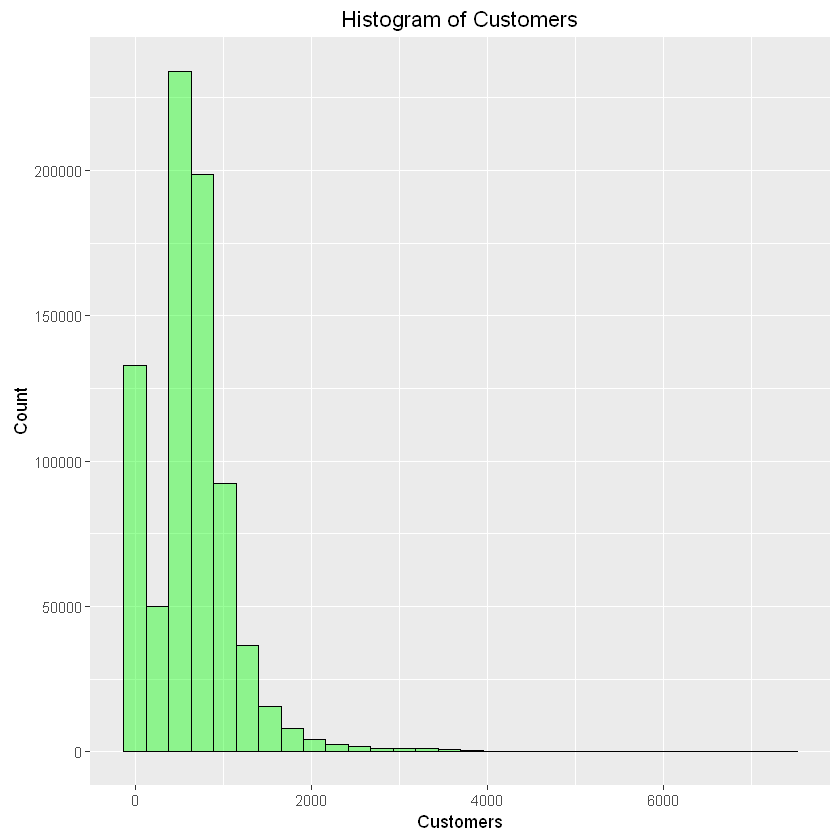

In [22]:
ggplot()+aes(train$Customers)+geom_histogram(col="black",fill="green",alpha=0.4)+
labs(title="Histogram of Customers") + labs(x="Customers", y="Count")
# It is Right skewed and with few records having customer count as 0

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
: Removed 132568 rows containing non-finite values (stat_bin).Warning message:
: Removed 1 rows containing missing values (geom_bar).

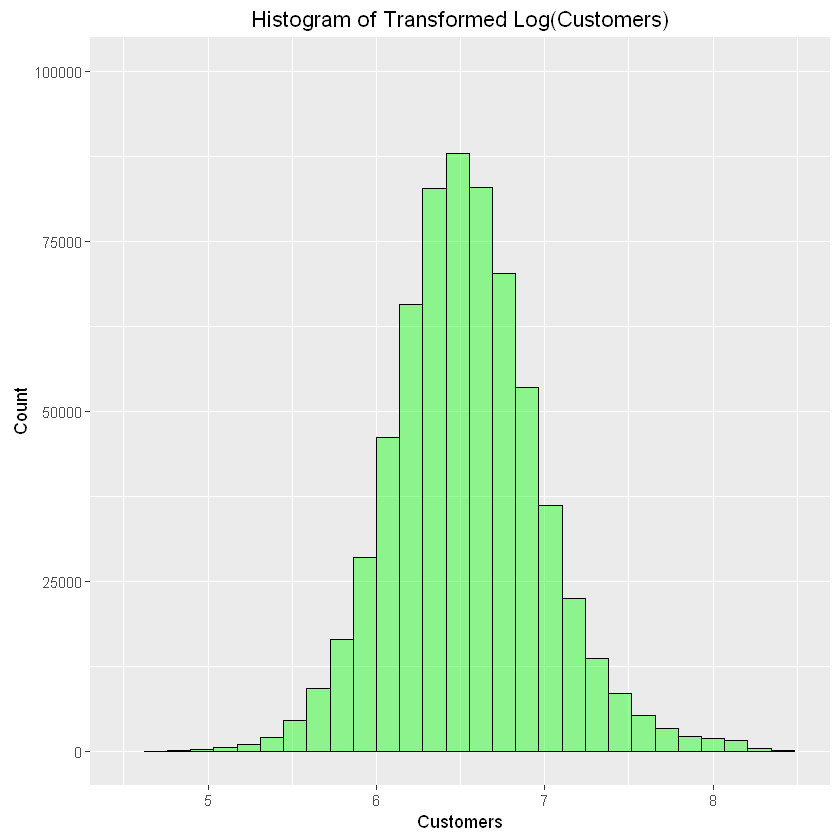

In [23]:
ggplot()+aes(log(train$Customers))+geom_histogram(col="black",fill="green",alpha=0.4)+
labs(title="Histogram of Transformed Log(Customers)") + labs(x="Customers", y="Count")+xlim(4.5,8.5)+ylim(0,100000)

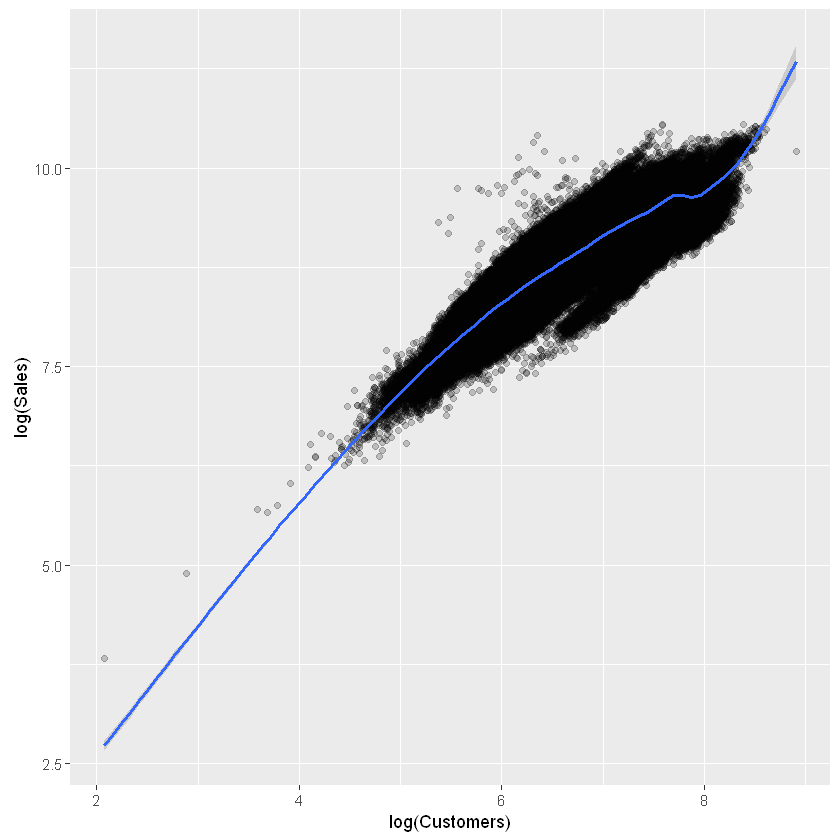

In [25]:
ggplot(train[train$Sales != 0 & train$Customers != 0], aes(x = log(Customers), y = log(Sales))) + geom_point(alpha = 0.2) + geom_smooth()
#Linear Relationship between log(Sales) and Log(Customers)

In [12]:
summary(train$Sales)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0    3683    5691    5742    7811   38040 

Warning message:
: Removed 15324 rows containing non-finite values (stat_boxplot).

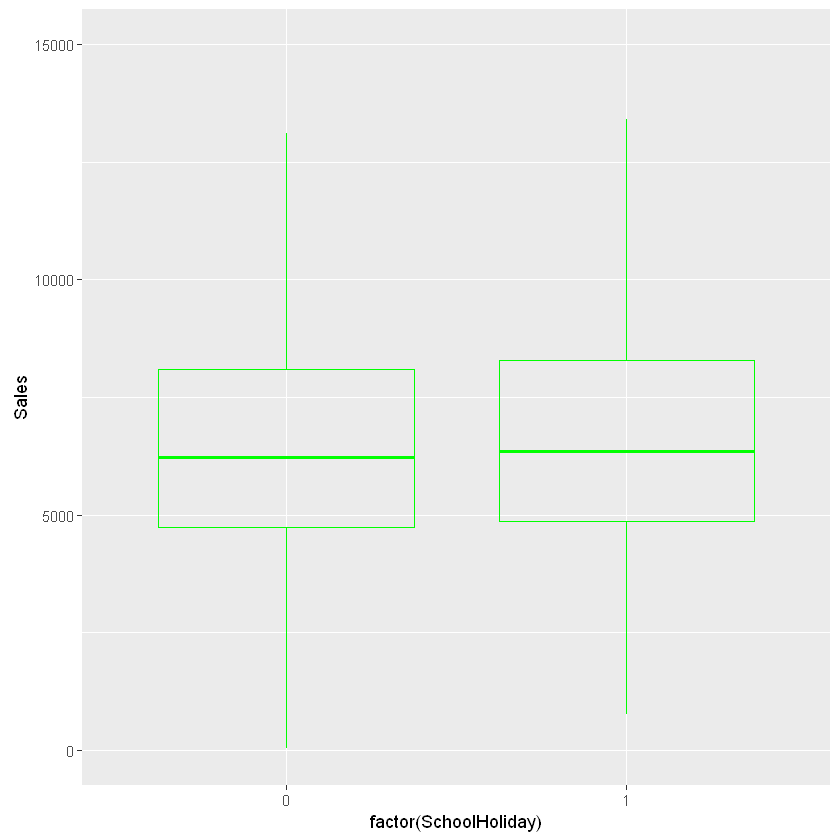

In [13]:
#Spread of sales when there is a School Holiday
ggplot(train[Sales != 0 & Customers != 0], aes(x = factor(SchoolHoliday), y = Sales))  + geom_boxplot(color = "green", outlier.colour = NA, fill = NA) + ylim(0,15000)
#there is slight difference in the mean sales when SchoolHoliday is there and when it is not there.


Warning message:
: Removed 15324 rows containing non-finite values (stat_boxplot).

[1] 5900.136

[1] 8207.701

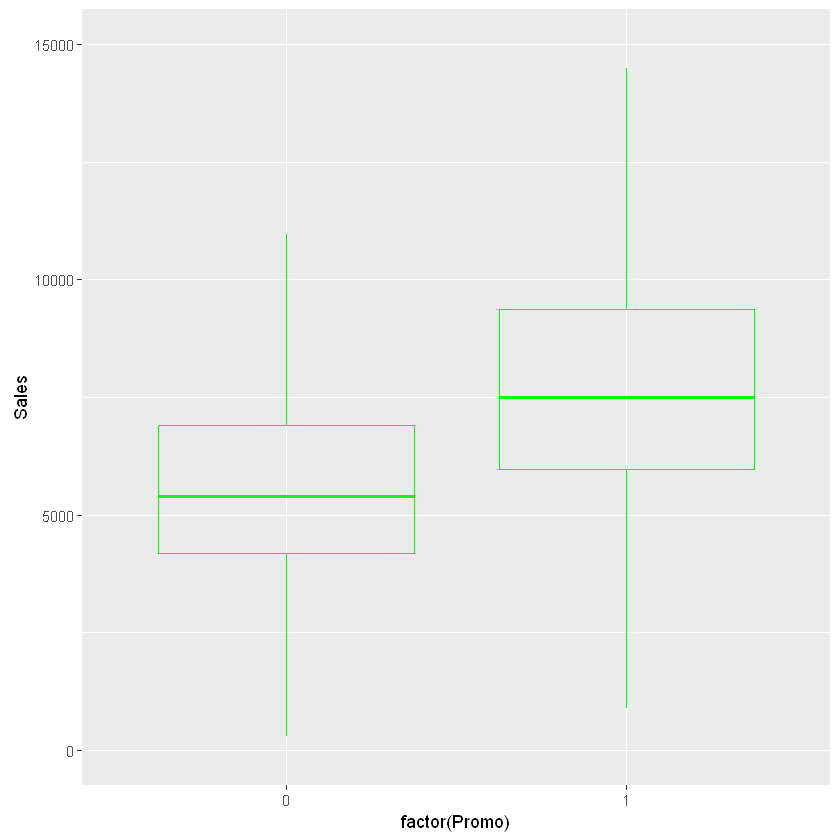

In [14]:
#Spread of Sales when Promo Code is taken into consideration.
ggplot(train[Sales != 0 & Customers != 0], aes(x = factor(Promo), y = Sales))  + geom_boxplot(color = "green", outlier.colour = NA, fill = NA) + ylim(0,15000)
# It can be seen that people tend to spend more when customers are offered with some sort of promotional offers.
mean(train[Sales != 0 & Customers !=0 & Promo == 0]$Sales)
mean(train[Sales != 0 & Customers !=0 & Promo == 1 ]$Sales)

Warning message:
: Removed 29271 rows containing non-finite values (stat_boxplot).

[1] 699.1703

[1] 850.5914

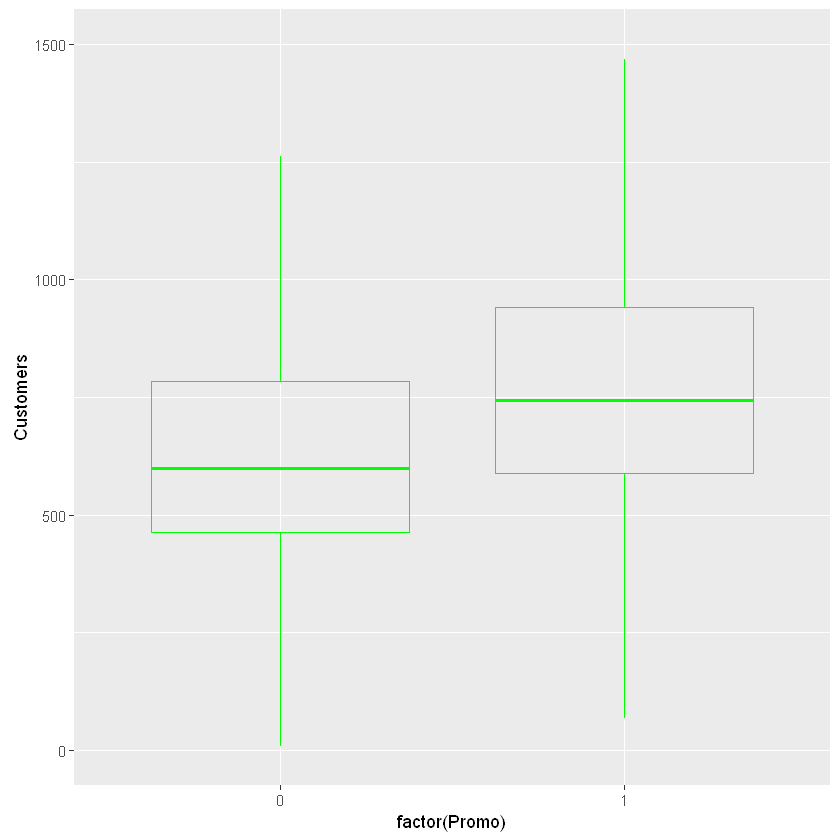

In [15]:
#Spread of Customers when Promo Code is taken into consideration
ggplot(train[Sales != 0 & Customers != 0], aes(x = factor(Promo), y = Customers))  + geom_boxplot(color = "green", outlier.colour = NA, fill = NA) + ylim(0,1500)
mean(train[Sales != 0 & Customers !=0 & Promo == 0]$Customers)
mean(train[Sales != 0 & Customers !=0 & Promo == 1]$Customers)
# we can see that there isn't any appreciable increment in the customer visiting the store when promotional codes are offered.
#However, it looks like people do tend to spend more.

In [16]:
table(ifelse(train$Open == 1, "Store Open", "Store Close"), ifelse(train$Sales > 0, "Sales > 0", "Sales = 0"))
# There are few stores for which Sales = 0 despite store being Open. This is bit strange. I can consider this as outlier.


             
              Sales = 0 Sales > 0
  Store Close    132469         0
  Store Open         51    648309

In [19]:
length(train[train$Sales == 0 & Open == 1]$Store) # 51 Stores ID listed.

[1] 51

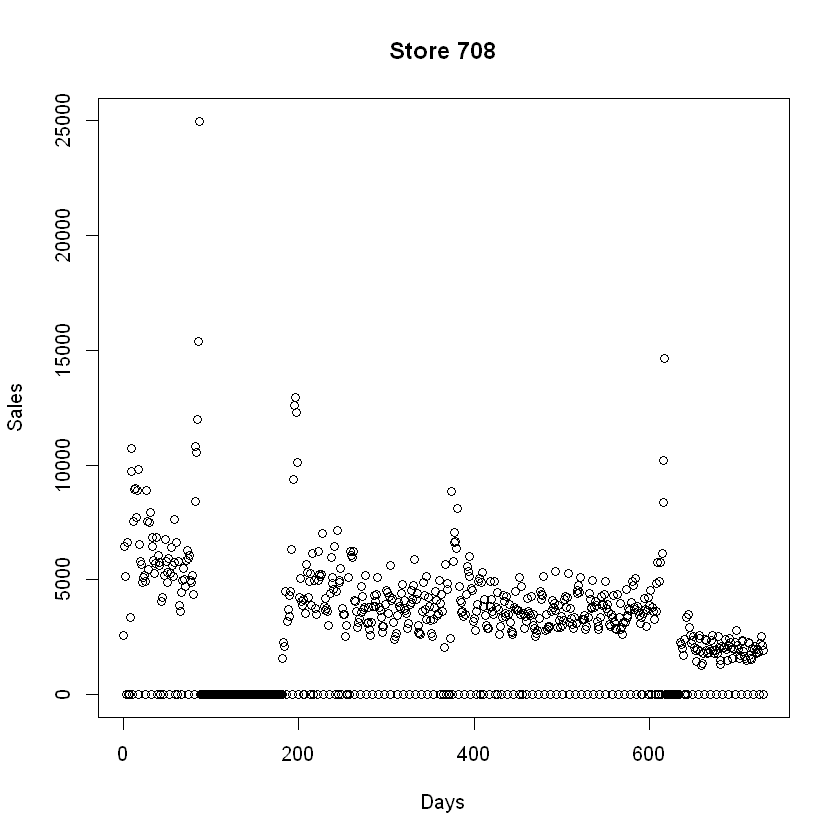

In [20]:
plot(train[Store == 708, Sales], ylab = "Sales", xlab = "Days", main = "Store 708")


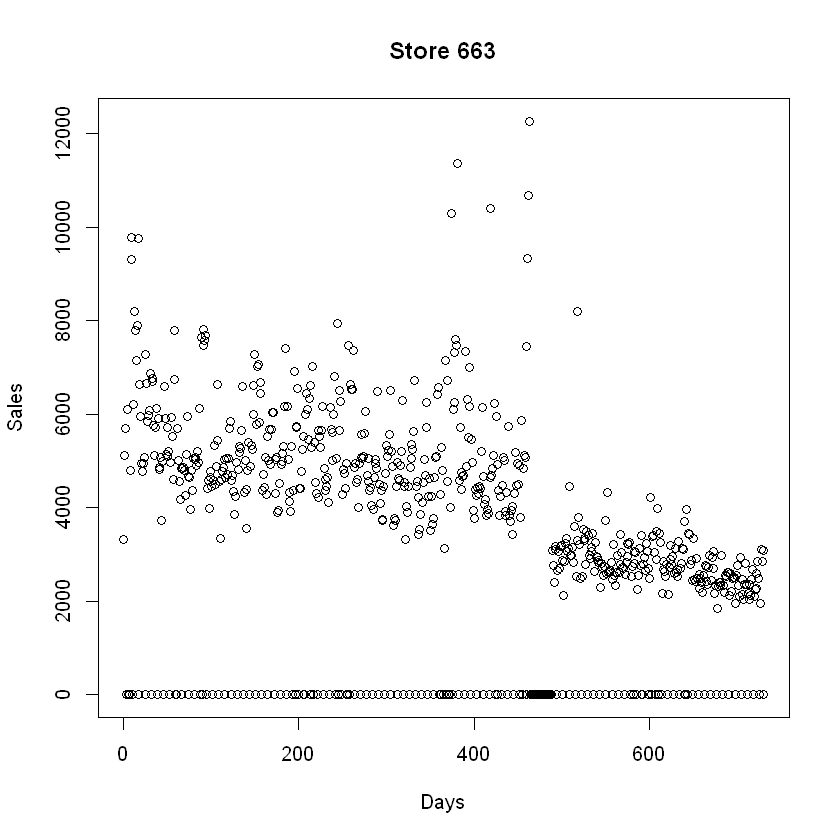

In [21]:
plot(train[Store == 663, Sales], ylab = "Sales", xlab = "Days", main = "Store 663")

In [22]:
tail(train[train$DayOfWeek == 7 & train$Open == 1]$Store)

[1]  682  733  769  863  948 1097

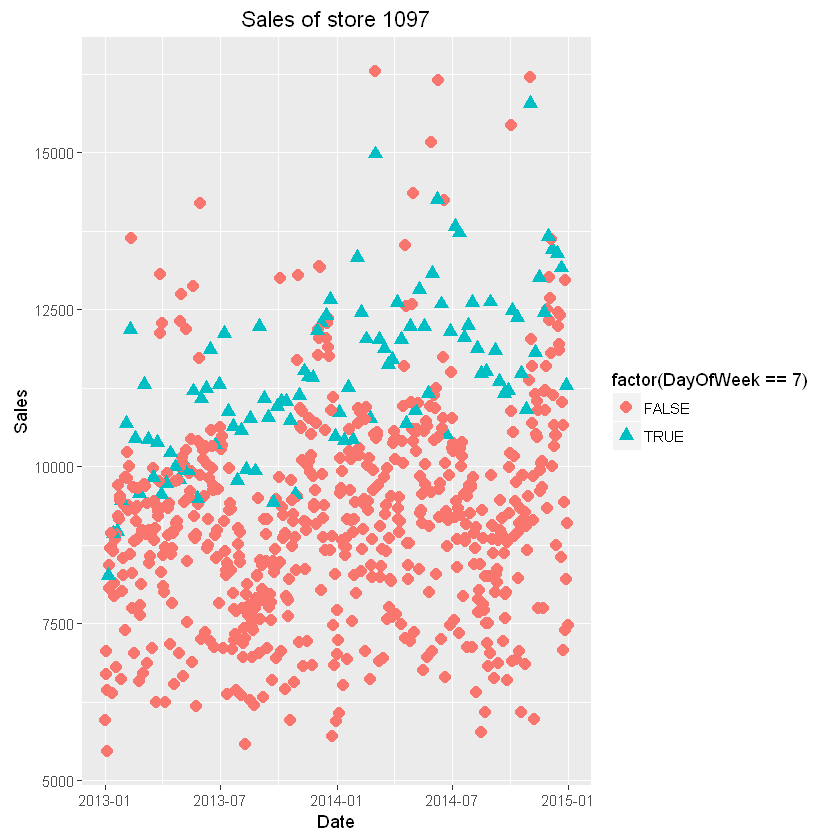

In [23]:
#There are store which are open on Sundays (DayOfWeek=7) and have sales higher than normal week days.
ggplot(train[Store == 1097], aes(x = Date, y = Sales, color = factor(DayOfWeek == 7), shape = factor(DayOfWeek == 7))) +   geom_point(size = 3) + ggtitle("Sales of store 1097")


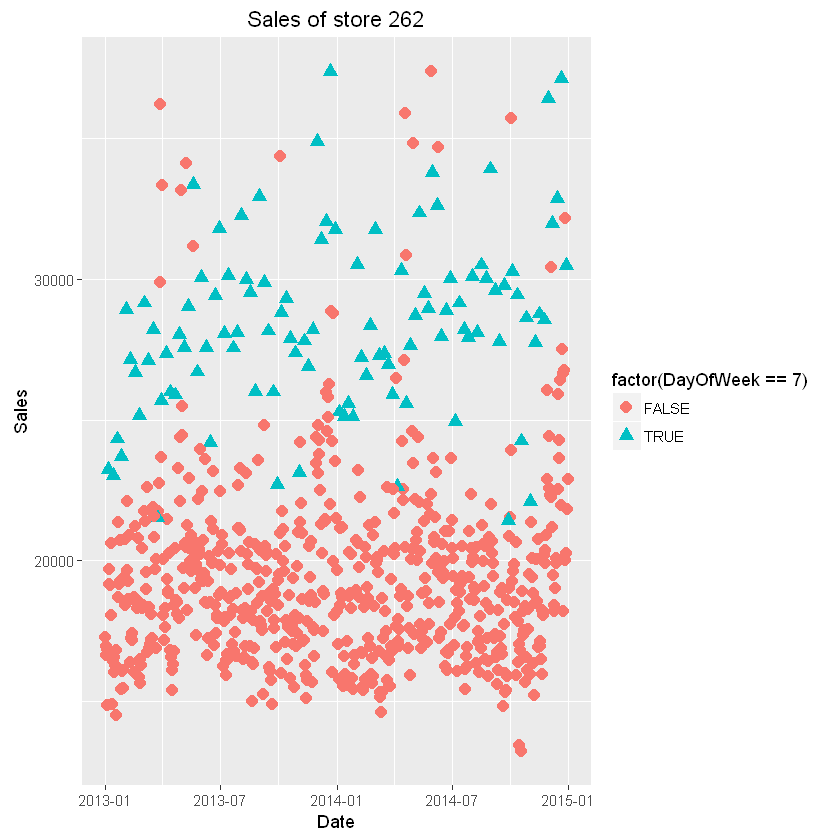

In [24]:
ggplot(train[Store == 262], aes(x = Date, y = Sales, color = factor(DayOfWeek == 7), shape = factor(DayOfWeek == 7))) + geom_point(size = 3) + ggtitle("Sales of store 262")


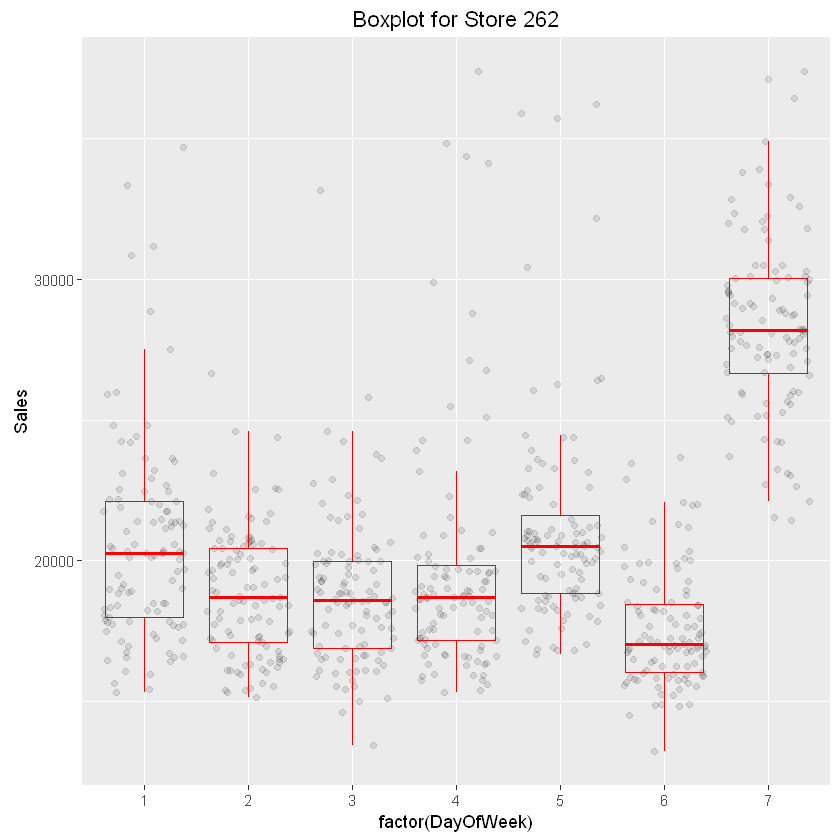

In [25]:
ggplot(train[train$Store == 262], aes(x=factor(DayOfWeek), y=Sales))+geom_jitter(alpha=0.1)+geom_boxplot(color='red', outlier.colour = NA, fill = NA) +ggtitle("Boxplot for Store 262")

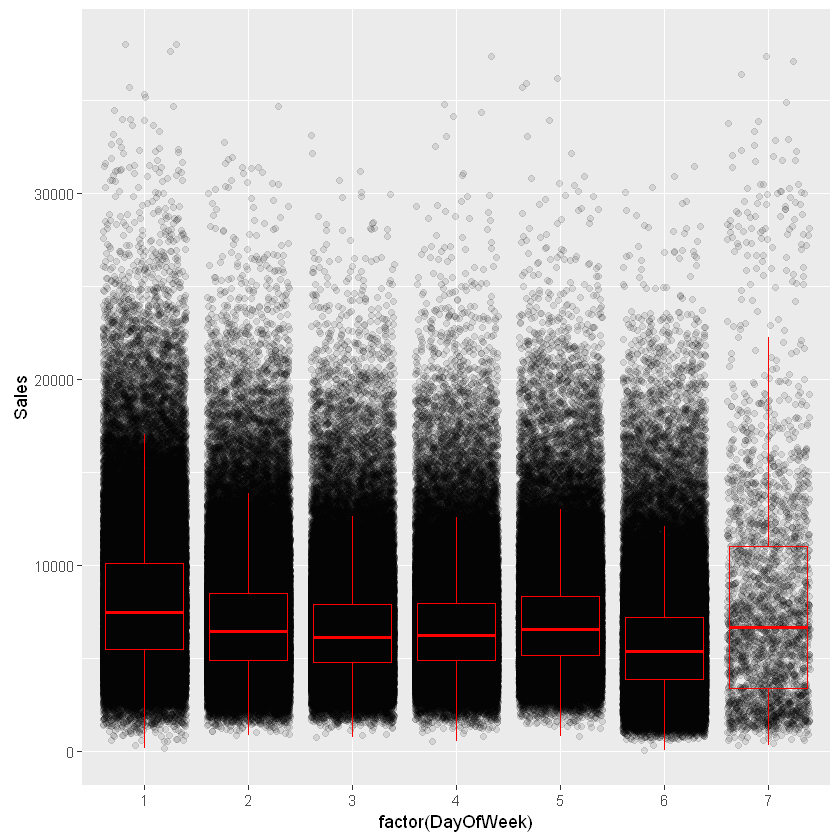

In [26]:
# we can see that spread observed for the Sunday is very wide.
ggplot(train[Sales != 0 & Customers != 0], aes(x = factor(DayOfWeek), y = Sales)) + geom_jitter(alpha = 0.1) +   geom_boxplot(color = "red", outlier.colour = NA, fill = NA)

In [27]:
#Importing STORE dataset and performing data exploration on it.

summary(store)

     Store         StoreType          Assortment        CompetitionDistance
 Min.   :   1.0   Length:1115        Length:1115        Min.   :   20.0    
 1st Qu.: 279.5   Class :character   Class :character   1st Qu.:  717.5    
 Median : 558.0   Mode  :character   Mode  :character   Median : 2325.0    
 Mean   : 558.0                                         Mean   : 5404.9    
 3rd Qu.: 836.5                                         3rd Qu.: 6882.5    
 Max.   :1115.0                                         Max.   :75860.0    
                                                        NA's   :3          
 CompetitionOpenSinceMonth CompetitionOpenSinceYear     Promo2      
 Min.   : 1.000            Min.   :1900             Min.   :0.0000  
 1st Qu.: 4.000            1st Qu.:2006             1st Qu.:0.0000  
 Median : 8.000            Median :2010             Median :1.0000  
 Mean   : 7.225            Mean   :2009             Mean   :0.5121  
 3rd Qu.:10.000            3rd Qu.:2013        

In [28]:
str(store)

Classes 'data.table' and 'data.frame':	1115 obs. of  10 variables:
 $ Store                    : int  1 2 3 4 5 6 7 8 9 10 ...
 $ StoreType                : chr  "c" "a" "a" "c" ...
 $ Assortment               : chr  "a" "a" "a" "c" ...
 $ CompetitionDistance      : int  1270 570 14130 620 29910 310 24000 7520 2030 3160 ...
 $ CompetitionOpenSinceMonth: int  9 11 12 9 4 12 4 10 8 9 ...
 $ CompetitionOpenSinceYear : int  2008 2007 2006 2009 2015 2013 2013 2014 2000 2009 ...
 $ Promo2                   : int  0 1 1 0 0 0 0 0 0 0 ...
 $ Promo2SinceWeek          : int  NA 13 14 NA NA NA NA NA NA NA ...
 $ Promo2SinceYear          : int  NA 2010 2011 NA NA NA NA NA NA NA ...
 $ PromoInterval            : chr  "" "Jan,Apr,Jul,Oct" "Jan,Apr,Jul,Oct" "" ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [29]:
names(store)

[1] "Store"                     "StoreType"                
 [3] "Assortment"                "CompetitionDistance"      
 [5] "CompetitionOpenSinceMonth" "CompetitionOpenSinceYear" 
 [7] "Promo2"                    "Promo2SinceWeek"          
 [9] "Promo2SinceYear"           "PromoInterval"

In [30]:
table(store$StoreType)


  a   b   c   d 
602  17 148 348 

In [31]:
table(store$Assortment)


  a   b   c 
593   9 513 

In [32]:
table(store$PromoInterval)


                  Feb,May,Aug,Nov  Jan,Apr,Jul,Oct Mar,Jun,Sept,Dec 
             544              130              335              106 

Warning message:
: Removed 3 rows containing non-finite values (stat_bin).

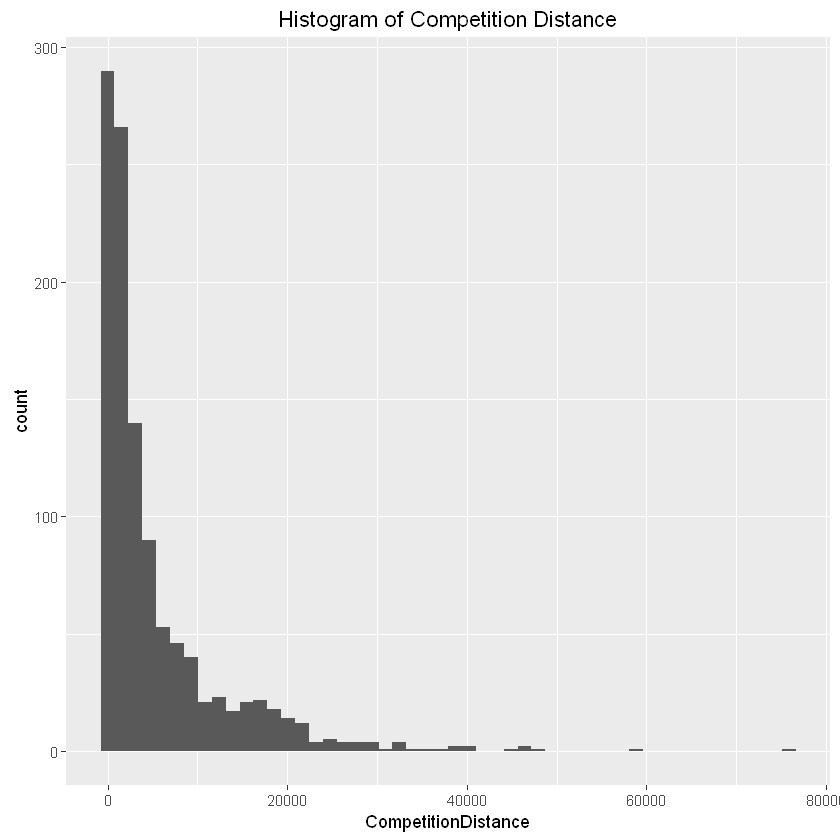

In [33]:
ggplot(store, aes(x=CompetitionDistance))+geom_histogram(bins = 50)+ggtitle("Histogram of Competition Distance")


Warning message:
: Removed 374 rows containing non-finite values (stat_bin).Warning message:
: Removed 1 rows containing missing values (geom_bar).

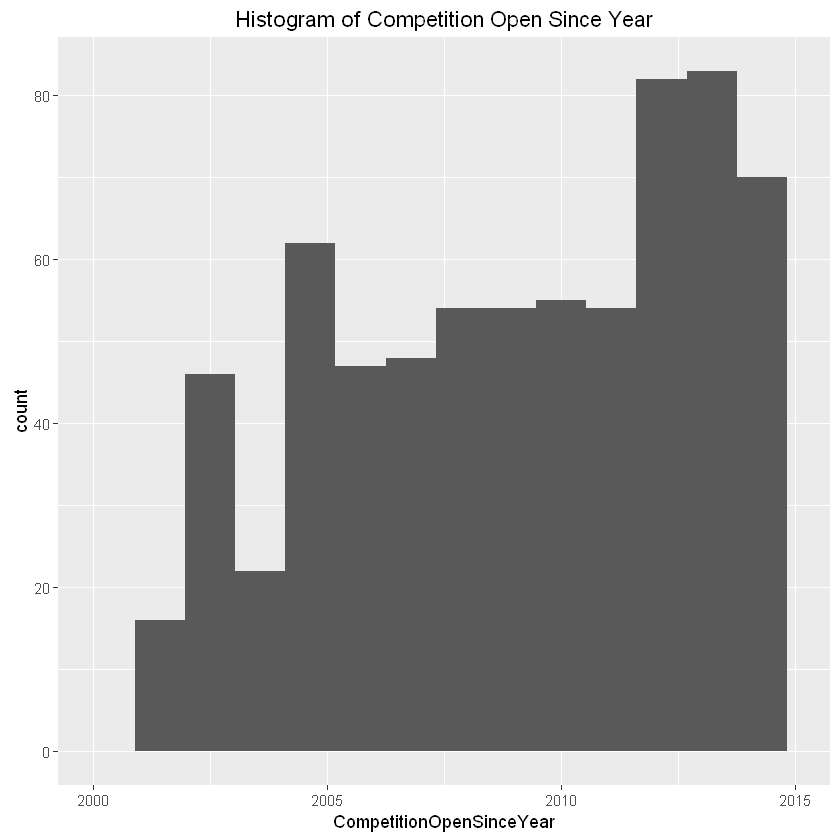

In [34]:
ggplot(store, aes(x=CompetitionOpenSinceYear))+geom_histogram(bins = 15)+ggtitle("Histogram of Competition Open Since Year")+xlim(2000,2015)
#Most stores were opened in the year after 2005

In [10]:
#Merging two datasets train and store.
trainStore <- merge(train, store, by = "Store")
testStore<-merge(test,store,by="Store")

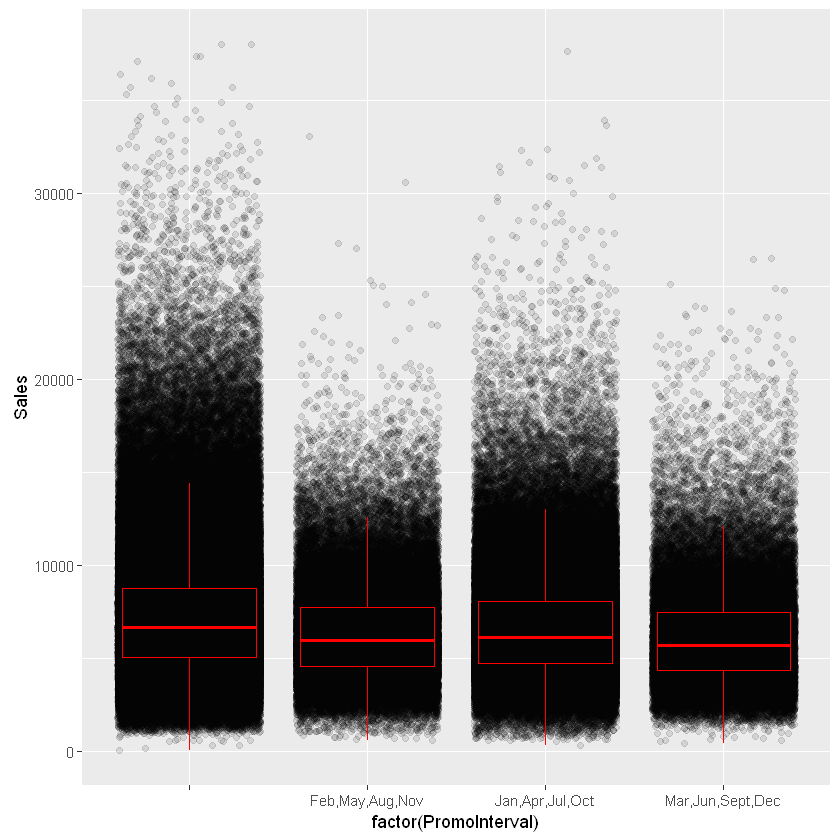

In [36]:
#We can see that for the PromoInterval 'Feb,May,Aug,Nov'. Minimum sales was clocked as compared to other intervals.
ggplot(trainStore[Sales != 0 & Customers != 0], aes(x = factor(PromoInterval), y = Sales)) + geom_jitter(alpha = 0.1) + geom_boxplot(color = "red", outlier.colour = NA, fill = NA)


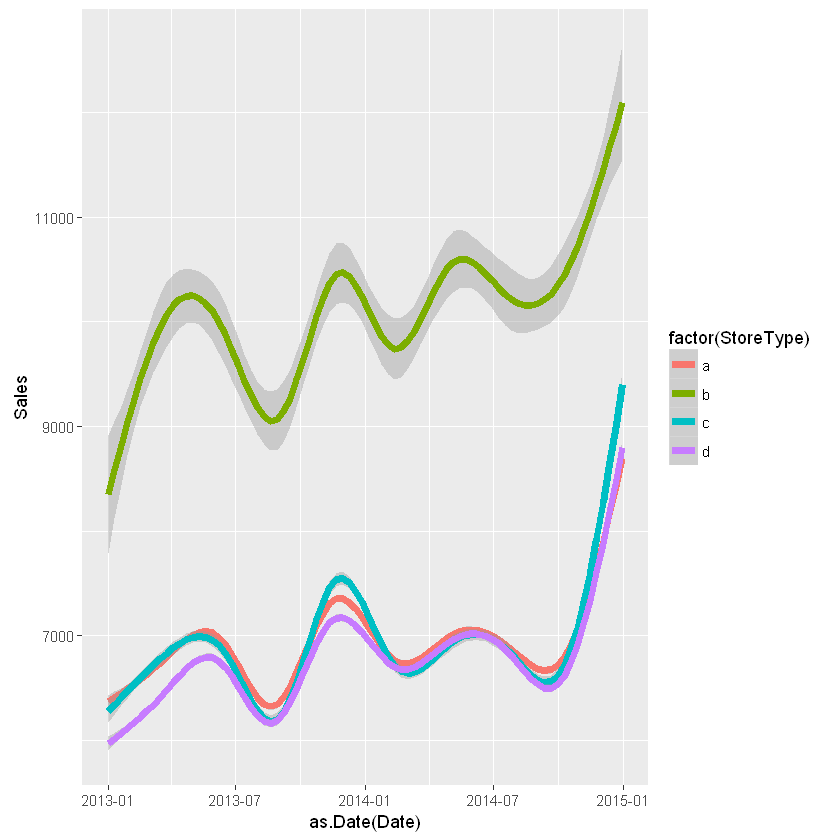

In [37]:
#StoreType = b has maximum sales across the given period
ggplot(trainStore[Sales != 0 & Customers != 0], aes(x = as.Date(Date), y = Sales, color = factor(StoreType))) +   geom_smooth(size = 2)

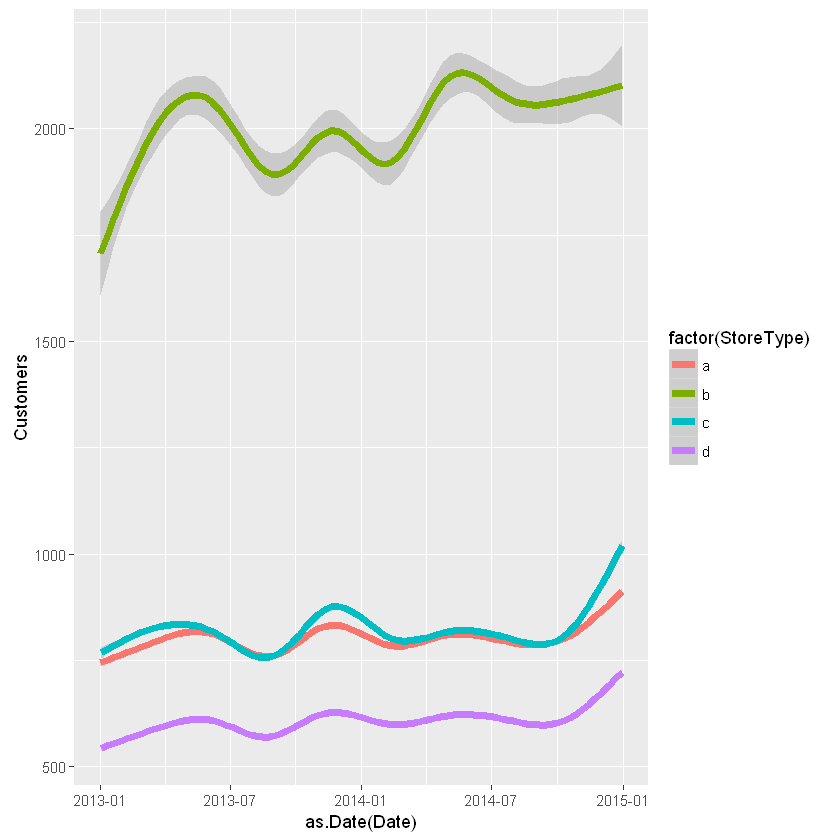

In [38]:
#StoreType b has maximum number of customer visiting the store.
ggplot(trainStore[Sales != 0 & Customers != 0], aes(x = as.Date(Date), y = Customers, color = factor(StoreType))) + geom_smooth(size = 2)

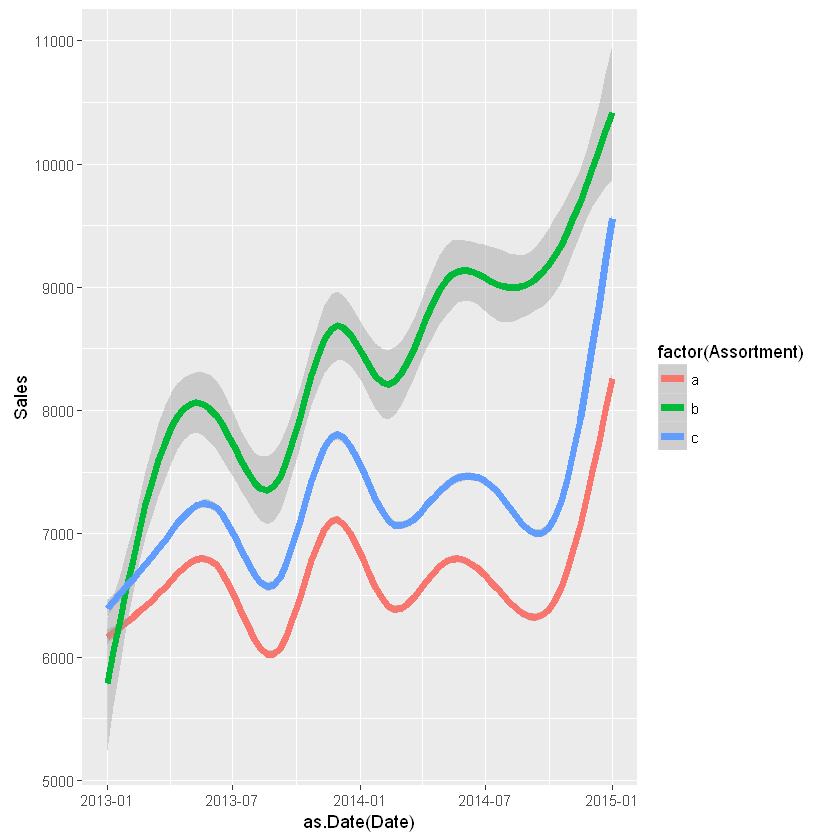

In [39]:
#Assortment type b has maximum sales clocked during the period
ggplot(trainStore[Sales != 0 & Customers != 0], aes(x = as.Date(Date), y = Sales, color = factor(Assortment))) +   geom_smooth(size = 2)

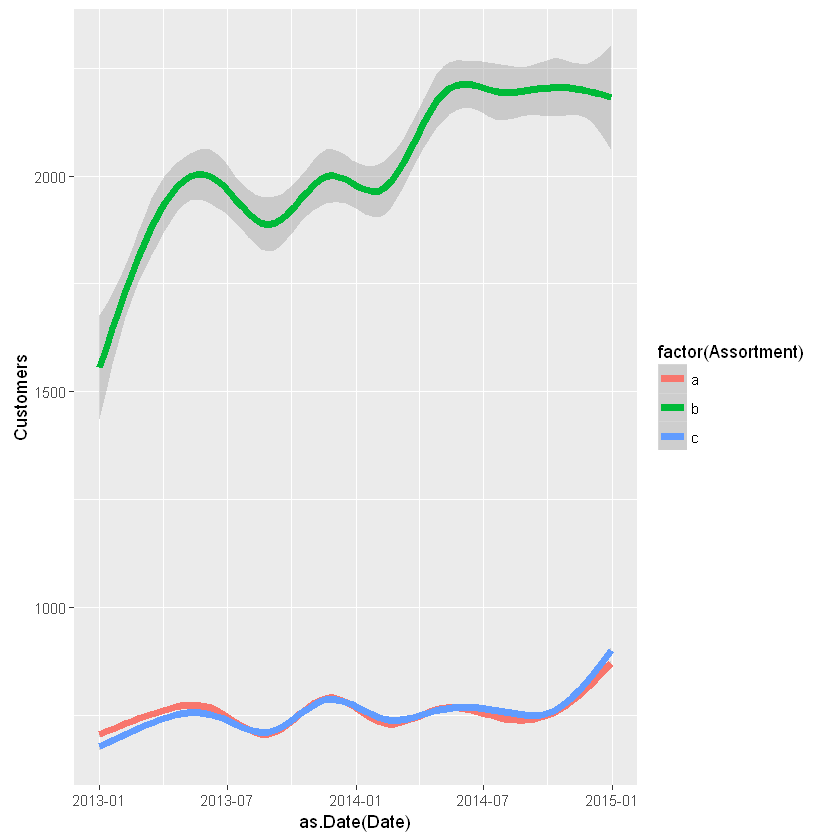

In [40]:
#Assortment Type b has extraordinary number of customer visiting the store
ggplot(trainStore[Sales != 0 & Customers != 0], aes(x = as.Date(Date), y = Customers, color = factor(Assortment))) +   geom_smooth(size = 2)

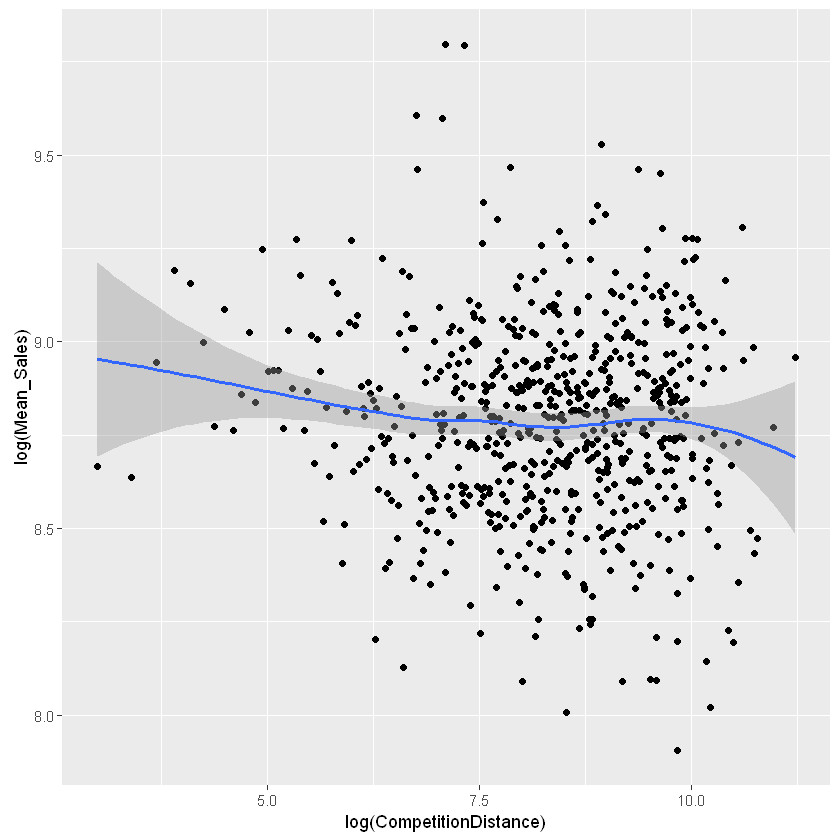

In [41]:
salesByDist <- aggregate(trainStore[Sales != 0 & !is.na(CompetitionDistance)]$Sales, by = list(trainStore[Sales != 0 & !is.na(CompetitionDistance)]$CompetitionDistance), mean)
colnames(salesByDist) <- c("CompetitionDistance", "Mean_Sales")
ggplot(salesByDist, aes(x = log(CompetitionDistance), y = log(Mean_Sales))) + geom_point() + geom_smooth()
#There is slight slope towards downward side which suggests that with increase in CompetitionDistance, Sales of the store tend to decrease.
#This can be justified with the fact that Urban areas will have competition stores more closely situation are more likely to give more sales
#as compared to the rural one where competitor stores will be situated at a distance and little less sales is clocked by them.

In [11]:
#Filtering records that have OPEN Stores

trainStore_open<-trainStore[trainStore$Open=="1"]
testStore_open<-testStore[testStore$Open=="1"]

In [12]:
#Transforming variable for modelling purpose

trainStore_open$DayOfWeek <- factor(trainStore_open$DayOfWeek)
testStore_open$DayOfWeek <- factor(testStore_open$DayOfWeek)

trainStore_open$Store <- factor(trainStore_open$Store)
testStore_open$Store <- factor(testStore_open$Store)

trainStore_open$Promo <- factor(trainStore_open$Promo)
testStore_open$Promo <- factor(testStore_open$Promo)

trainStore_open$SchoolHoliday <- factor(trainStore_open$SchoolHoliday)
testStore_open$SchoolHoliday <- factor(testStore_open$SchoolHoliday)

trainStore_open$Assortment<-factor(trainStore_open$Assortment)
testStore_open$Assortment<-factor(testStore_open$Assortment)

trainStore_open$StoreType<-factor(trainStore_open$StoreType)
testStore_open$StoreType<-factor(testStore_open$StoreType)

trainStore_open[trainStore_open$StateHoliday=="a"]$StateHoliday<-"1"
trainStore_open[trainStore_open$StateHoliday=="b"]$StateHoliday<-"1"
trainStore_open[trainStore_open$StateHoliday=="c"]$StateHoliday<-"1"
testStore_open[testStore_open$StateHoliday=="a"]$StateHoliday<-"1"
testStore_open[testStore_open$StateHoliday=="b"]$StateHoliday<-"1"
testStore_open[testStore_open$StateHoliday=="c"]$StateHoliday<-"1"
testStore_open$StateHoliday<-factor(testStore_open$StateHoliday)
trainStore_open$StateHoliday<-factor(trainStore_open$StateHoliday)

trainStore_open$CompetitionOpenSinceMonth<-factor(trainStore_open$CompetitionOpenSinceMonth)
testStore_open$CompetitionOpenSinceMonth<-factor(testStore_open$CompetitionOpenSinceMonth)

trainStore_open$CompetitionOpenSinceYear<-factor(trainStore_open$CompetitionOpenSinceYear)
testStore_open$CompetitionOpenSinceYear<-factor(testStore_open$CompetitionOpenSinceYear)

trainStore_open$Promo2<-factor(trainStore_open$Promo2)
testStore_open$Promo2<-factor(testStore_open$Promo2)

trainStore_open$PromoInterval<-factor(trainStore_open$PromoInterval)
testStore_open$PromoInterval<-factor(testStore_open$PromoInterval)

trainStore_open$Promo2SinceWeek<-factor(trainStore_open$Promo2SinceWeek)
testStore_open$Promo2SinceWeek<-factor(testStore_open$Promo2SinceWeek)

trainStore_open$Promo2SinceYear<-factor(trainStore_open$Promo2SinceYear)
testStore_open$Promo2SinceYear<-factor(testStore_open$Promo2SinceYear)

str(trainStore_open)
str(testStore_open)

Classes 'data.table' and 'data.frame':	648360 obs. of  18 variables:
 $ Store                    : Factor w/ 1115 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ DayOfWeek                : Factor w/ 7 levels "1","2","3","4",..: 3 2 1 6 3 2 1 6 5 4 ...
 $ Date                     : Date, format: "2014-12-31" "2014-12-30" ...
 $ Sales                    : int  2605 6466 6463 6057 3659 7959 9331 8367 7558 7785 ...
 $ Customers                : int  327 703 700 684 421 957 1080 962 884 841 ...
 $ Open                     : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Promo                    : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 2 2 ...
 $ StateHoliday             : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ SchoolHoliday            : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 1 1 1 ...
 $ StoreType                : Factor w/ 4 levels "a","b","c","d": 3 3 3 3 3 3 3 3 3 3 ...
 $ Assortment               : Factor w/ 3 levels "a","b","c": 1 1 1 1 1 1 1 1 1 1 ...
 $ CompetitionDist

# Predictive Model Building

# 1. Linear Regression (OLS)

In [13]:
##Model Building##
#Linear Regression
model_lm<-lm(Sales~Customers+DayOfWeek+Promo+StateHoliday+SchoolHoliday+Assortment+StoreType+Promo2,data=trainStore_open)
testStore_open$predSales_lm<-predict(model_lm,testStore_open)

In [15]:
rmse(testStore_open$predSales_lm,testStore_open$Sales)

[1] 1323.486

# 2. Decision Tree

In [19]:
trainStore_open$logSales<-log1p(trainStore_open$Sales)
model3=rpart(logSales~Customers+DayOfWeek+Promo+StateHoliday+SchoolHoliday+StoreType+Promo+Promo2+Assortment, data=trainStore_open, method='anova', control=rpart.control(minsplit=30, cp=0.001))
predictions<-as.data.frame(predict(model3,testStore_open))
testStore_open$predSales_tree<-expm1(predictions[,1])

In [20]:
rmse(testStore_open$Sales,testStore_open$predSales_tree)

[1] 1441.802

# 3. Random Forest

In [21]:
model4=randomForest(Sales~Customers+DayOfWeek+Promo+StateHoliday+SchoolHoliday+StoreType+Promo+Promo2+Assortment, data=trainStore_open, ntree=10)
testStore_open$predSales_rf<-predict(model4,testStore_open)

In [22]:
rmse(testStore_open$Sales,testStore_open$predSales_rf)

[1] 1520.201

# 4. H20 Random Forest

In [23]:
trainStore_open$logSales<-log1p(trainStore_open$Sales)
h2o.init(nthreads=-1)
trainHex<-as.h2o(trainStore_open)
names(trainStore_open)
features<-colnames(trainStore_open)[!(colnames(trainStore_open) %in% c("Store","Date","Sales","logSales"))]

rfHex <- h2o.randomForest(x=features,
                          y="logSales", 
                          ntrees = 10,
                          max_depth = 30,
                          nbins_cats = 1115, ## allow it to fit store ID
                          training_frame=trainHex)
summary(rfHex)
testHex<-as.h2o(testStore_open)
predictions<-as.data.frame(h2o.predict(rfHex,testHex))
testStore_open$predSales_h2o<-expm1(predictions[,1])

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         4 hours 6 minutes 
    H2O cluster version:        3.8.3.3 
    H2O cluster name:           H2O_started_from_R_jagpreet_ckf206 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.55 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    R Version:                  R version 3.3.1 (2016-06-21) 

  |======================================================================| 100%


[1] "Store"                     "DayOfWeek"                
 [3] "Date"                      "Sales"                    
 [5] "Customers"                 "Open"                     
 [7] "Promo"                     "StateHoliday"             
 [9] "SchoolHoliday"             "StoreType"                
[11] "Assortment"                "CompetitionDistance"      
[13] "CompetitionOpenSinceMonth" "CompetitionOpenSinceYear" 
[15] "Promo2"                    "Promo2SinceWeek"          
[17] "Promo2SinceYear"           "PromoInterval"            
[19] "logSales"

Warning message:
In .h2o.startModelJob(algo, params, h2oRestApiVersion): Dropping constant columns: [Open].


  |======================================================================| 100%
Model Details:

H2ORegressionModel: drf
Model Key:  DRF_model_R_1470620481372_2 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1              10                       10            35098772        30
  max_depth mean_depth min_leaves max_leaves  mean_leaves
1        30   30.00000     252585     302486 276672.10000

H2ORegressionMetrics: drf
** Reported on training data. **
Description: Metrics reported on Out-Of-Bag training samples

MSE:  0.01798065
R2 :  0.9054255
Mean Residual Deviance :  0.01798065





Scoring History: 
             timestamp          duration number_of_trees training_MSE
1  2016-08-08 01:48:00         0.010 sec               0             
2  2016-08-08 01:48:11        10.508 sec               1      0.01354
3  2016-08-08 01:48:20        19.833 sec               2      0.04880
4  2016-08-08 01:48:31        30.511 sec               3      0.03

In [24]:
rmse(testStore_open$Sales,testStore_open$predSales_h2o) 

[1] 684.6492